# Kernel Density estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity, NearestNeighbors
from scipy.stats import norm

### Synthetic data

In [2]:
# Set random seed for reproducibility
np.random.seed(41)

def generate_weird_data(N=1000):
    
    X1 = np.random.normal(loc=-3, scale=0.8, size=N//2)  # Gaussian 1
    X2 = np.random.normal(loc=3, scale=1.2, size=N//2)   # Gaussian 2

    X = np.concatenate([X1, X2])  # Merge two Gaussians
    # X += 0.5 * np.sin(2 * X)      # Add sine perturbation

    return X

def exact_mixture_pdf(x):
    """Compute the exact mixture PDF (without sine perturbation)."""
    w1, w2 = 0.5, 0.5  # Weights of each Gaussian
    pdf1 = norm.pdf(x, loc=-3, scale=0.8)  # First Gaussian
    pdf2 = norm.pdf(x, loc=3, scale=1.2)   # Second Gaussian
    return w1 * pdf1 + w2 * pdf2  # Mixture of Gaussians

### KDE

In [3]:

def kde_sklearn(X, bandwidth=0.5, num_points=200):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')  # Gaussian KDE
    kde.fit(X[:, None])  # Fit KDE model (reshape X to 2D)

    x_grid = np.linspace(min(X)-1, max(X)+1, num_points)[:, None]  # Define range for estimation
    log_density = kde.score_samples(x_grid)  # Compute log-density
    density = np.exp(log_density)  # Convert log-density to normal density
    return x_grid.ravel(), density

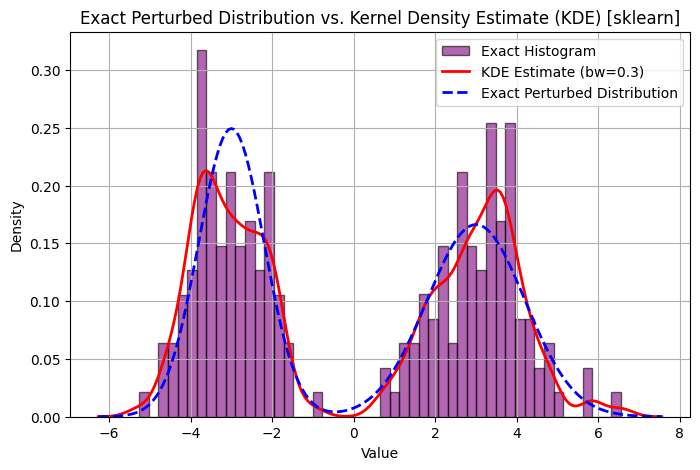

In [4]:
# Generate synthetic data
N = 200
X = generate_weird_data(N)

# Fit KDE with sklearn
bandwidth = 0.3  # Adjust this value to control smoothness
x_grid, kde_pdf = kde_sklearn(X, bandwidth=bandwidth)

# Compute exact perturbed PDF
exact_perturbed_pdf = exact_mixture_pdf(x_grid)

# Plot comparison: Histogram, KDE, and Exact Perturbed PDF
plt.figure(figsize=(8, 5))
plt.hist(X, bins=50, density=True, alpha=0.6, color='purple', edgecolor='black', label="Exact Histogram")
plt.plot(x_grid, kde_pdf, color='red', linewidth=2, label=f"KDE Estimate (bw={bandwidth})")
plt.plot(x_grid, exact_perturbed_pdf, color='blue', linestyle='--', linewidth=2, label="Exact Perturbed Distribution")

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Exact Perturbed Distribution vs. Kernel Density Estimate (KDE) [sklearn]")
plt.legend()
plt.grid()
plt.show()

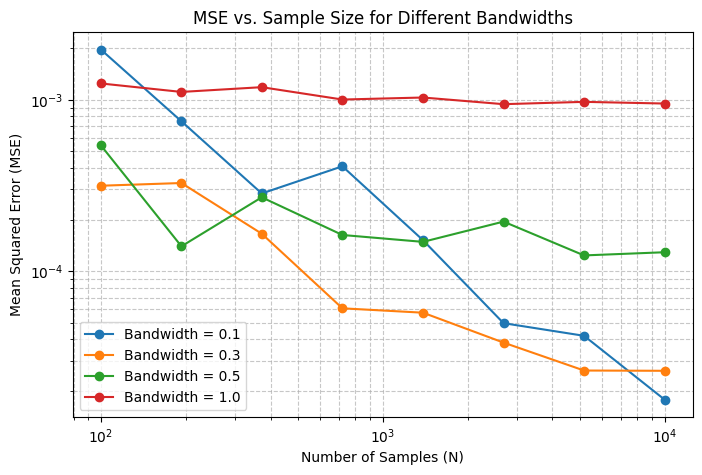

In [5]:
def compute_mse(N, bandwidth=0.3):
    """Compute MSE between KDE and exact perturbed PDF for given N."""
    X = generate_weird_data(N)  # Generate samples
    x_grid, kde_pdf = kde_sklearn(X, bandwidth=bandwidth)  # Compute KDE
    exact_pdf = exact_mixture_pdf(x_grid)  # Compute exact perturbed PDF
    
    mse = np.mean((kde_pdf - exact_pdf) ** 2)  # Compute MSE
    return mse

# Experiment with different sample sizes and bandwidths
N_values = np.logspace(2, 4, 8, dtype=int)  # Sample sizes from 100 to 10,000
bandwidth_values = [0.1, 0.3, 0.5, 1.0]  # Different bandwidths for KDE
mse_results = {bw: [compute_mse(N, bw) for N in N_values] for bw in bandwidth_values}

# Plot MSE for different bandwidths
plt.figure(figsize=(8, 5))
for bw in bandwidth_values:
    plt.loglog(N_values, mse_results[bw], marker='o', linestyle='-', label=f"Bandwidth = {bw}")

plt.xlabel("Number of Samples (N)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs. Sample Size for Different Bandwidths")
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

# KNN (uses binary-tree which is logn)

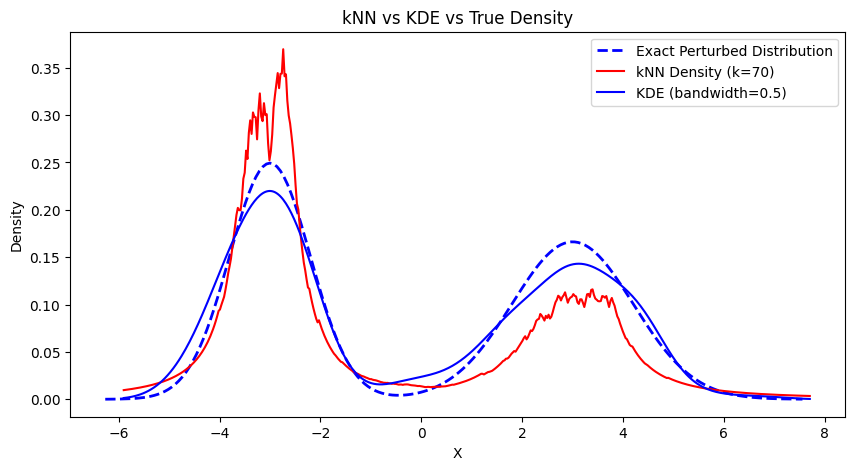

In [15]:

# Create dataset
N = 300
X = generate_weird_data(N)
X = X.reshape(-1, 1)  # Reshape for sklearn

# Define range for density estimation
X_grid = np.linspace(min(X)-1, max(X)+1, 500).reshape(-1, 1)
# Compute true density histogram
hist, bin_edges = np.histogram(X, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of bins

# kNN density estimation
k = 70  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
distances, _ = nbrs.kneighbors(X_grid)
V_k = np.pi * distances[:, -1]**2  # Approximate volume in 1D
knn_density = k / (N * V_k)  # Density estimate

# KDE for comparison
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(X)
kde_density = np.exp(kde.score_samples(X_grid))

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(x_grid, exact_perturbed_pdf, color='blue', linestyle='--', linewidth=2, label="Exact Perturbed Distribution")
plt.plot(X_grid, knn_density, label=f"kNN Density (k={k})", color='red')
plt.plot(X_grid, kde_density, label="KDE (bandwidth=0.5)", color='blue')
plt.xlabel("X")
plt.ylabel("Density")
plt.title("kNN vs KDE vs True Density")
plt.legend()
plt.show()